# Testing the NMO

In [1]:
import pickle
import json
import orsa
import numpy as np
import pandas as pd
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns
import copy
import matplotlib as mpl
import pkg_resources
import matplotlib.gridspec as gridspec

sns.set(style = 'white')
mpl.rc('xtick.minor', visible = True)
mpl.rc('ytick.minor', visible = True)
mpl.rc('xtick', direction='in', top=True, bottom = True)
mpl.rc('ytick', direction='in', right=True, left = True)

print(orsa.__version__)

0.7.0


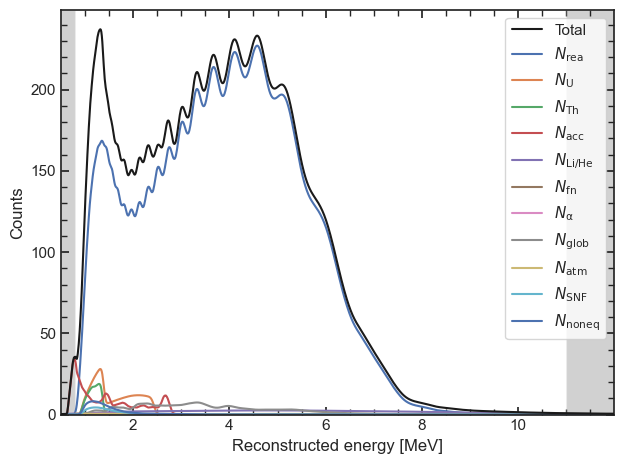

In [29]:
model = orsa.model.read_json('0_test_model.json') # true NMO is NO for this model

model.oscillation.ordering = 'NO'
model.parameters['dm2_31'].value = model.oscillation.dm2_31
model.parameters['dm2_21'].value = model.oscillation.dm2_21
model.parameters['s2_12'].value = model.oscillation.s2_12
model.parameters['s2_13'].value = model.oscillation.s2_13

# # Paper NMO - NO
# model.oscillation.ordering = 'NO'
# model.parameters['dm2_21'].value = 7.53e-5
# model.parameters['dm2_31'].value = model.parameters['dm2_21'].value + 2.453e-3
# model.parameters['s2_12'].value = 0.307
# model.parameters['s2_13'].value = 0.0218

# # Paper NMO - IO
# model.oscillation.ordering = 'IO'
# model.parameters['dm2_21'].value = 7.53e-5
# model.parameters['dm2_31'].value = model.parameters['dm2_21'].value - 2.546e-3
# model.parameters['s2_12'].value = 0.307
# model.parameters['s2_13'].value = 0.0218

model.exposure = 6*365.25
model

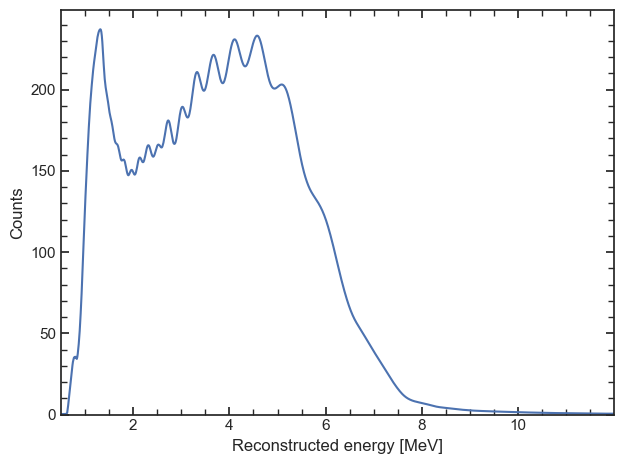

In [30]:
data = model.get_spectrum(asimov = True)
data

In [31]:
fit_model_true_NMO = model.copy()
fit_model_wrong_NMO = model.copy()
fit_model_wrong_NMO.parameters['dm2_31'].value = -model.parameters['dm2_31'].value

In [32]:
min_func_bin = orsa.probability.CostFunction(ll=orsa.probability.chi2, ll_args=dict(data=data), lp_args=model.get_priors())
model.use_shape_uncertainty = True
res_true_NMO = orsa.fit.minuit(model, min_func_bin, init_model = fit_model_true_NMO)
res_wrong_NMO = orsa.fit.minuit(model, min_func_bin, init_model = fit_model_wrong_NMO)

Cost function parsed as chi2-like
Cost function parsed as chi2-like


In [33]:
res_true_NMO.obj.valid, res_wrong_NMO.obj.valid, round(res_wrong_NMO.obj.fval - res_true_NMO.obj.fval, 3)

(True, True, 8.071)

8.568470757753836

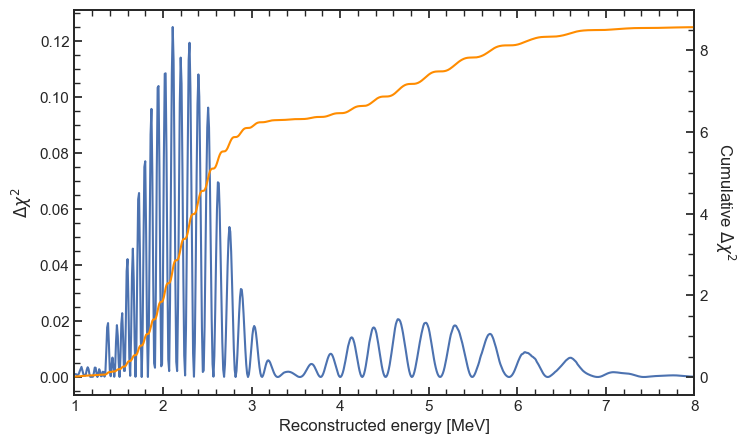

In [26]:
def calc_chi2(data, model, which='C', V_syst=None):

    M_, T_ = orsa.probability.get_hists(data, model)

    M, T = orsa.utils.clean_zeros(M_, T_, 'left')

    if which == 'P':
        V_stat = T
    elif which == 'N':
        V_stat = M
    elif which == 'C':
        V_stat = (3./(1./M + 2./T))
    else:
        raise Exception('Choose between P, N, C!')

    if model.use_shape_uncertainty:
        V_shape_ = orsa.probability.calc_V_shape(model)
        _, V_shape = orsa.utils.clean_zeros(M_, V_shape_, 'left')

    else:
        V_shape = np.zeros(V_stat.shape)

    ##############################################################################
    
    if type(V_syst) == type(None):
        V_syst = np.zeros(V_stat.shape)
    else:
        V_stat = V_stat*np.identity(T.shape[0])
        V_shape = V_shape*np.identity(T.shape[0])

    V = V_stat + V_syst + V_shape
    
    
    return ((M-T)**2/V)


fig, ax = plt.subplots(figsize = (8,5))

asimov_true_NMO = res_true_NMO.model.get_spectrum(asimov = True)
asimov_wrong_NMO = res_wrong_NMO.model.get_spectrum(asimov = True)

chi2_true_NMO = calc_chi2(data, res_true_NMO.model)
chi2_wrong_NMO = calc_chi2(data, res_wrong_NMO.model)
chi2 = chi2_wrong_NMO - chi2_true_NMO

ax.plot(asimov_true_NMO.E, chi2, 'b-')
ax2 = ax.twinx()
ax2.plot(asimov_true_NMO.E, np.cumsum(chi2), c = 'darkorange')
ax.set_xlim(1,8)

ax.set_xlabel('Reconstructed energy [MeV]')
ax.set_ylabel(r'$\Delta \chi^2$')
ax2.set_ylabel(r'Cumulative $\Delta \chi^2$', rotation = -90, va = 'bottom', ha = 'center')

chi2.sum()

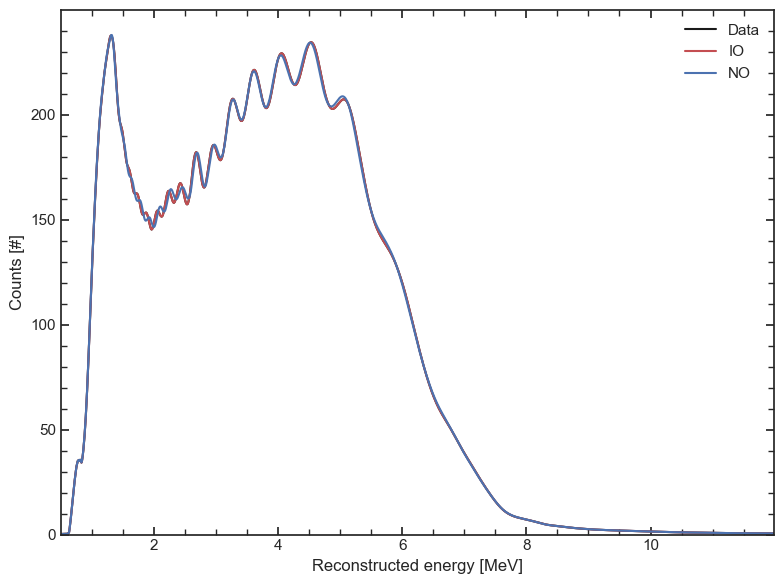

In [27]:
fig, ax = plt.subplots(figsize = (8,6))

def get_ordering(model):
    if model.parameters['dm2_31'].value > 0: return 'NO'
    elif model.parameters['dm2_31'].value < 0: return 'IO'
    else:
        raise Exception()

ax.plot(data.E, data.counts, 'k-', label = 'Data')
ax.plot(asimov_true_NMO.E, asimov_true_NMO.counts, 'r-', label = get_ordering(res_true_NMO.model))
ax.plot(asimov_wrong_NMO.E, asimov_wrong_NMO.counts, 'b-', label = get_ordering(res_wrong_NMO.model))
ax.set_xlim(model.E_eval.min(), model.E_eval.max())
ax.set_ylim(bottom = False)
ax.set_xlabel('Reconstructed energy [MeV]')
ax.set_ylabel('Counts [#]')

ax.legend(frameon = False)
fig.tight_layout()